In [1]:
import matplotlib
#matplotlib.use('agg')

from ase.io import read,write
import ase.build
import numpy as np
from phonopy.structure.atoms import PhonopyAtoms
import API_phonopy as api_ph
import API_phonopy_lammps as api_pl
from phonopy import Phonopy
import phonopy.file_IO as PhonIO
from phonopy.interface.calculator import get_default_physical_units
import copy as cp
import os
import phonopy.interface.vasp as Intf_vasp 

import AllenFeldman as AF
from phonopy.interface.vasp import read_vasp,write_vasp
from hiphive import ForceConstants

import API_thirdorder as FC3
import thirdorder_core
import thirdorder_common
import matplotlib.pyplot as plt

from phonopy.units import EV, Angstrom, Kb, THz, THzToEv,Hbar

- Storing the coefficients in a dense matrix
(3, 3, 3, 2, 54, 54)


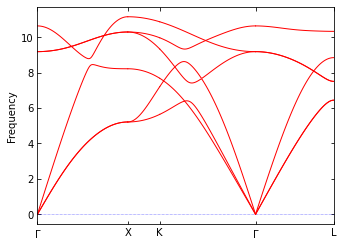

In [2]:
# Need to activate phono3py environment. 
#Temperatures = [300] multiple temperatures.
T = 300
Qpoints=np.array([[0.0001,0.0001,1.0],[0.5,0.5,1.0],[3./8,3./8,3./4],[0.0,0.0,0.0],[0.5,0.5,0.5]])
band_labels=['$\Gamma$','X','K','$\Gamma$','L']

Nrepeat=[3,3,3]
mesh = [9,9,9]
nneigh = 3

poscar = 'POSCAR'

cmds = ["pair_style eim","pair_coeff * * Na Cl ffield.eim Na Cl"]

Band_points=100
NAC = True
interface_mode = 'vasp'


# compute FC2
prim_cell = Intf_vasp.read_vasp(poscar)
phonon = Phonopy(prim_cell,np.diag(Nrepeat))
phonon.generate_displacements(distance=0.03) # vasp
Scell0 = api_ph.phonopyAtoms_to_aseAtoms(phonon.get_supercell())

Scells_ph = phonon.get_supercells_with_displacements() # This returns a list of Phononpy atoms object

forces = api_pl.calc_lmp_force_sets(cmds,Scells_ph)
phonon.set_forces(forces)
PhonIO.write_FORCE_SETS(phonon.get_displacement_dataset()) # write forces & displacements to FORCE_SET
force_set=PhonIO.parse_FORCE_SETS() # parse force_sets
phonon.set_displacement_dataset(force_set) # force_set is a list of forces and displacements

if NAC == True:
    nac_params = PhonIO.get_born_parameters(
            open("BORN"),
            phonon.get_primitive(),
            phonon.get_primitive_symmetry())
    if nac_params['factor'] == None:
        physical_units = get_default_physical_units(interface_mode)
        nac_params['factor'] = physical_units['nac_factor']
    phonon._nac_params=nac_params


phonon.produce_force_constants()
phonon.symmetrize_force_constants()
api_ph.write_ShengBTE_FC2(phonon.get_force_constants(), filename='FORCE_CONSTANTS_2ND')
fc2 = phonon.get_force_constants() # get fc2.

# plot dispersion
bands=api_ph.qpoints_Band_paths(Qpoints,Band_points)
phonon.set_band_structure(bands,is_eigenvectors=True,labels=band_labels)
phonon.write_yaml_band_structure()
bs_plt=phonon.plot_band_structure()
bs_plt.xlabel("")
bs_plt.ylabel("Frequency (THz)",fontsize=16)
bs_plt.xticks(fontsize=16)
bs_plt.yticks(fontsize=16)
bs_plt.savefig("Bandstructure.png",dpi=300,bbox_inches='tight')


# compute FC3

poscar = FC3.read_POSCAR(".")
natoms = len(poscar["types"])
symops = thirdorder_core.SymmetryOperations(poscar["lattvec"], poscar["types"], poscar["positions"].T, 1e-5) # symops is an obj.
sposcar = FC3.gen_SPOSCAR(poscar, Nrepeat[0], Nrepeat[1], Nrepeat[2])
FC3.write_POSCAR(sposcar,'SPOSCAR')
ntot = natoms * np.prod(Nrepeat)
dmin, nequi, shifts = FC3.calc_dists(sposcar)
frange = FC3.calc_frange(poscar, sposcar, nneigh, dmin)


wedge = thirdorder_core.Wedge(poscar, sposcar, symops, dmin, nequi, shifts,frange)
list4 = wedge.build_list4()
nirred = len(list4)
nruns = 4 * nirred
width = len(str(4 * (len(list4) + 1)))
namepattern = "3RD.POSCAR.{{0:0{0}d}}".format(width)


Scells = []
phipart = np.zeros((3, nirred, ntot))
p = FC3.build_unpermutation(sposcar)
for i, e in enumerate(list4):
    for n in range(4): 
        isign = (-1)**(n // 2)
        jsign = -(-1)**(n % 2)
        # Start numbering the files at 1 for aesthetic
        # reasons.
        number = nirred * n + i + 1 # the number doesn't follow the order of 1,2,3,... 
        dsposcar = FC3.normalize_SPOSCAR(FC3.move_two_atoms(sposcar, e[1], e[3], isign * thirdorder_common.H, e[0], e[2], jsign * thirdorder_common.H))
        filename = namepattern.format(number)
        FC3.write_POSCAR(dsposcar, filename)
        Scell = read_vasp(filename)
        Scells.append(Scell)
        os.remove(filename)
        #print number
        Scell_ase = api_ph.phonopyAtoms_to_aseAtoms(Scell)
        force = np.array(api_pl.calc_lmp_force(cmds,Scell_ase))
        phipart[:, i, :] -= isign * jsign * force[p, :].T   
     
phipart /= (400. * thirdorder_common.H * thirdorder_common.H)
phifull = thirdorder_core.reconstruct_ifcs(phipart, wedge, list4,poscar, sposcar)
print(phifull.shape)
thirdorder_common.write_ifcs(phifull, poscar, sposcar, dmin, nequi, shifts, frange,"FORCE_CONSTANTS_3RD")

# convert FC3 shengBTE to fc3 for phono3py.
prim = read('POSCAR')
supercell = read('SPOSCAR')
fc3 = ForceConstants.read_shengBTE(supercell, 'FORCE_CONSTANTS_3RD', prim)

api_ph.write_phonopy_fc2_hdf5('fc2.hdf5',fc2)
api_ph.write_phonopy_fc3_hdf5('fc3.hdf5',fc3)

In [ ]:
# under construction, compute QHGK thermal conductivity
kappa_sym,kappa_ph_sym,Kxx_mp,Kyy_mp,Kzz_mp = AF.calc_QHGK_phono3py_at_T(phonon,mesh,T,NAC)




        _                      _____
  _ __ | |__   ___  _ __   ___|___ / _ __  _   _
 | '_ \| '_ \ / _ \| '_ \ / _ \ |_ \| '_ \| | | |
 | |_) | | | | (_) | | | | (_) |__) | |_) | |_| |
 | .__/|_| |_|\___/|_| |_|\___/____/| .__/ \__, |
 |_|                                |_|    |___/ 
                                       2.3.2

Python version 3.9.12
Spglib version 1.16.2
----------------------------- General settings -----------------------------
Run mode: conductivity-RTA
HDF5 data compression filter: gzip
Crystal structure was read from "POSCAR".
Supercell (dim): [3 3 3]
Spacegroup: Fm-3m (225)
Use -v option to watch primitive cell, unit cell, and supercell structures.
NAC parameters were read from "BORN".
----------------------------- Force constants ------------------------------
Imposing translational and index exchange symmetry to fc2: False
Imposing translational and index exchange symmetry to fc3: False
Reading fc3 from "fc3.hdf5".
Max drift of fc3: 0.000002 (xxy) 0.000002 (x

Number of triplets: 125
Frequency     group velocity (x, y, z)     |gv|  (dq=1.0e-05)
   5.335   (  29.700  -29.700    0.000)   42.002
   5.801   (  31.000  -31.000    0.000)   43.840
   7.563   ( -12.453   12.453   -0.000)   17.612
   7.898   (  28.591  -28.591    0.000)   40.433
   9.638   (  -9.794    9.794   -0.000)   13.851
   9.983   (   8.980   -8.980    0.000)   12.700
======================= Grid point 30 (20/35) =======================
q-point: ( 0.33  0.33  0.00)
Boundary mean free path (millimetre): 1000.000
Number of triplets: 75
Frequency     group velocity (x, y, z)     |gv|  (dq=1.0e-05)
   4.565   (   0.000    0.000   21.567)   21.567
   4.565   (   0.000    0.000   21.567)   21.567
   8.395   (  -0.000   -0.000   -8.340)    8.340
   9.489   (   0.000    0.000   52.204)   52.204
   9.990   (   0.000    0.000    9.360)    9.360
   9.990   (   0.000    0.000    9.360)    9.360
======================= Grid point 31 (21/35) =======================
q-point: ( 0.44  0.33  0.

/home/xinqian/Softwares/API_Phonons/AllenFeldman.py:422: RuntimeWarning: invalid value encountered in true_divide
  Tau_sr = Num/Den # ps


In [ ]:
print('QHGK kappa = ')
print(kappa_sym)
print('Phonon kappa = ')
print(kappa_ph_sym)
    

In [ ]:
#flatten the Kxx_mp and plot. for NaCl crystals, only the diagonal of kmn should be important.

Nq,Nbrch = Kxx_mp.shape[:2]

Kxx_mp_flat = np.zeros((Nq*Nbrch,Nq*Nbrch))

for iq in range(Nq):
    Kxx_mp_flat[iq*Nbrch:(iq+1)*Nbrch,iq*Nbrch:(iq+1)*Nbrch] = Kxx_mp[iq]
    

plt.imshow(Kxx_mp_flat)
plt.colorbar(label='$\kappa_{mn}$ (W/m$\cdot$K)')
ax = plt.gca()
ax.invert_yaxis()
plt.clim([0,0.02])
plt.xlabel('Mode indices m=(q,s)')
plt.ylabel('Mode indices n=(q\',s\')')
